In [106]:
import pandas as pd
from sklearn.linear_model import Ridge
import lightgbm as lgb
from sklearn.ensemble import BaggingRegressor

import numba
import joblib

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import pandas_datareader.data as DataReader
import yfinance as yfin
yfin.pdr_override()

In [123]:
# topix2000 etf
df = pd.read_csv("TOPIX.csv", encoding="shift-jis")
df['Date'] = pd.to_datetime(df['日付'], format='%Y%m%d')
df['year'] = df['Date'].dt.year
df = df.sort_values(by='Date').set_index('Date')
display.display(df)

# dow
# df_dow = DataReader.get_data_yahoo('^DJI', start="2000-01-01")
# df_dow.to_pickle('dow.pkl')
df_dow = pd.read_pickle('dow.pkl')
display.display(df_dow)

# マージ
df = pd.merge(
    left=df.reset_index(), right=df_dow.reset_index(), how='left'
).fillna(method='ffill').set_index('Date').dropna()
df.to_pickle('df_merge.pkl')
df

,日付,始値,高値,安値,終値,5日平均,25日平均,75日平均,VWAP,出来高,5日平均.1,25日平均.1,year
Date,,,,,,,,,,,,,
2001-07-13,20010713,1258.0,1258.0,1239.0,1241.0,--,--,--,1244.0900,706400,--,--,2001
2001-07-16,20010716,1245.0,1249.0,1237.0,1241.0,--,--,--,1243.8700,50200,--,--,2001
2001-07-17,20010717,1225.0,1229.0,1220.0,1224.0,--,--,--,1224.2600,78700,--,--,2001
2001-07-18,20010718,1226.0,1226.0,1197.0,1199.0,--,--,--,1210.9200,113100,--,--,2001
2001-07-19,20010719,1195.0,1200.0,1189.0,1193.0,1219.6,--,--,1192.8100,93400,208360,--,2001
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-23,20211223,2083.0,2092.0,2080.5,2091.5,2073.2,2085.1,2115.2,2085.7434,50160,148202,187695.2,2021
2021-12-24,20211224,2097.5,2100.0,2089.0,2089.5,2073.5,2083.12,2114.68,2092.9405,75260,110780,183347.2,2021
2021-12-27,20211227,2089.5,2090.5,2080.0,2080.5,2081.4,2080.3,2113.71,2085.8059,46760,90654,179079.2,2021


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1999-12-31,11453.480469,11542.410156,11442.820312,11497.120117,11497.120117,43620000
2000-01-03,11501.849609,11522.009766,11305.690430,11357.509766,11357.509766,169750000
2000-01-04,11349.750000,11350.059570,10986.450195,10997.929688,10997.929688,178420000
2000-01-05,10989.370117,11215.099609,10938.669922,11122.650391,11122.650391,203190000
2000-01-06,11113.370117,11313.450195,11098.450195,11253.259766,11253.259766,176550000
...,...,...,...,...,...,...
2021-12-22,35491.710938,35764.671875,35433.128906,35753.890625,35753.890625,281930000
2021-12-23,35782.421875,36060.988281,35782.421875,35950.558594,35950.558594,247420000
2021-12-27,35954.480469,36306.609375,35954.480469,36302.378906,36302.378906,244350000


,日付,始値,高値,安値,終値,5日平均,25日平均,75日平均,VWAP,出来高,5日平均.1,25日平均.1,year,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,,,,,,,,,,,,,,
2001-07-13,20010713,1258.0,1258.0,1239.0,1241.0,--,--,--,1244.0900,706400,--,--,2001,10478.389648,10549.759766,10432.599609,10539.059570,10539.059570,200390000.0
2001-07-16,20010716,1245.0,1249.0,1237.0,1241.0,--,--,--,1243.8700,50200,--,--,2001,10537.980469,10568.690430,10446.599609,10472.120117,10472.120117,220170000.0
2001-07-17,20010717,1225.0,1229.0,1220.0,1224.0,--,--,--,1224.2600,78700,--,--,2001,10468.620117,10628.480469,10438.660156,10606.389648,10606.389648,283640000.0
2001-07-18,20010718,1226.0,1226.0,1197.0,1199.0,--,--,--,1210.9200,113100,--,--,2001,10594.540039,10594.540039,10480.879883,10569.830078,10569.830078,261170000.0
2001-07-19,20010719,1195.0,1200.0,1189.0,1193.0,1219.6,--,--,1192.8100,93400,208360,--,2001,10574.330078,10679.120117,10523.919922,10610.000000,10610.000000,235870000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-23,20211223,2083.0,2092.0,2080.5,2091.5,2073.2,2085.1,2115.2,2085.7434,50160,148202,187695.2,2021,35782.421875,36060.988281,35782.421875,35950.558594,35950.558594,247420000.0
2021-12-24,20211224,2097.5,2100.0,2089.0,2089.5,2073.5,2083.12,2114.68,2092.9405,75260,110780,183347.2,2021,35782.421875,36060.988281,35782.421875,35950.558594,35950.558594,247420000.0
2021-12-27,20211227,2089.5,2090.5,2080.0,2080.5,2081.4,2080.3,2113.71,2085.8059,46760,90654,179079.2,2021,35954.480469,36306.609375,35954.480469,36302.378906,36302.378906,244350000.0


In [144]:
df = pd.read_pickle('df_merge.pkl')

# 特徴量作成
def make_feature(df):
    df = df.assign(
        o2c = lambda df: df['終値']/df['始値']-1,
        
        c2o = lambda df: df['始値']/df['終値'].shift(1)-1,
        dow_o2c = lambda df: df.Close.shift(1).astype(float)/df.Open.shift(1).astype(float)-1,

        pre_o2c = lambda df: df.o2c.shift(1),
        pre_c2o = lambda df: df['始値'].shift(1)/df['終値'].shift(2)-1,

        pre_o2c2 = lambda df: df.pre_o2c.shift(1),
        pre_c2o2 = lambda df: df.pre_c2o.shift(1),

        pre_o2c3 = lambda df: df.pre_o2c.shift(1),
        pre_c2o3 = lambda df: df.pre_c2o.shift(1),
    )
    return df

df = make_feature(df)
df

,日付,始値,高値,安値,終値,5日平均,25日平均,75日平均,VWAP,出来高,...,Volume,o2c,c2o,dow_o2c,pre_o2c,pre_c2o,pre_o2c2,pre_c2o2,pre_o2c3,pre_c2o3
Date,,,,,,,,,,,,,,,,,,,,,
2001-07-13,20010713,1258.0,1258.0,1239.0,1241.0,--,--,--,1244.0900,706400,...,200390000.0,-0.013514,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-07-16,20010716,1245.0,1249.0,1237.0,1241.0,--,--,--,1243.8700,50200,...,220170000.0,-0.003213,0.003223,0.005790,-0.013514,NaN,NaN,NaN,NaN,NaN
2001-07-17,20010717,1225.0,1229.0,1220.0,1224.0,--,--,--,1224.2600,78700,...,283640000.0,-0.000816,-0.012893,-0.006250,-0.003213,0.003223,-0.013514,NaN,-0.013514,NaN
2001-07-18,20010718,1226.0,1226.0,1197.0,1199.0,--,--,--,1210.9200,113100,...,261170000.0,-0.022023,0.001634,0.013160,-0.000816,-0.012893,-0.003213,0.003223,-0.003213,0.003223
2001-07-19,20010719,1195.0,1200.0,1189.0,1193.0,1219.6,--,--,1192.8100,93400,...,235870000.0,-0.001674,-0.003336,-0.002332,-0.022023,0.001634,-0.000816,-0.012893,-0.000816,-0.012893
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-23,20211223,2083.0,2092.0,2080.5,2091.5,2073.2,2085.1,2115.2,2085.7434,50160,...,247420000.0,0.004081,0.004097,0.007387,-0.000482,0.002173,0.000483,0.014209,0.000483,0.014209
2021-12-24,20211224,2097.5,2100.0,2089.0,2089.5,2073.5,2083.12,2114.68,2092.9405,75260,...,247420000.0,-0.003814,0.002869,0.004699,0.004081,0.004097,-0.000482,0.002173,-0.000482,0.002173
2021-12-27,20211227,2089.5,2090.5,2080.0,2080.5,2081.4,2080.3,2113.71,2085.8059,46760,...,244350000.0,-0.004307,0.000000,0.004699,-0.003814,0.002869,0.004081,0.004097,0.004081,0.004097


In [145]:
# 特徴量リスト
feature1 = ['pre_o2c', 'pre_c2o', 'pre_o2c2', 'pre_c2o2', 'pre_o2c3', 'pre_c2o3', 'dow_o2c']

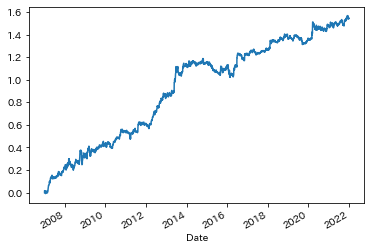

In [157]:
# model検証

X = df[feature1].fillna(0).values
y = df.o2c.fillna(0).values

pred = np.zeros_like(y)

for year in range(2005,2022,1):
    X_train = X[(df.index.year<year)&(df.index.year>year-15)]
    y_train = y[(df.index.year<year)&(df.index.year>year-15)]
    
    model_o2c = Ridge(alpha=1.0)
    model_o2c.fit(X_train, y_train)
    
    X_test = X[df.index.year==year]
    pred[df.index.year==year] = model_o2c.predict(X_test)

df['pred1'] = pred
df = df.assign(
    exec1 = lambda df: ((df['終値'].shift(1)*0.999<=df['始値'])&(df.pred1<=-0.000))|((df['終値'].shift(1)*1.001>=df['始値'])&(df.pred1>0.000)),
    rate1 = lambda df: (df.o2c * df.pred1.apply(lambda x: 1 if x>0.000 else -1 if  x<-0.000 else 0)).apply(lambda x: 0 if x==0 else x-0.04/365) * df.exec1,
)

df[df.index.year>=2007].rate1.cumsum().plot()
# plt.yscale('log')
plt.show()

In [153]:
# model deploy
year = 2022
X_train = X[(df.index.year<year)&(df.index.year>year-15)]
y_train = y[(df.index.year<year)&(df.index.year>year-15)]

model_o2c = Ridge(alpha=1.0)
model_o2c.fit(X_train, y_train)

joblib.dump(model_o2c, 'model_o2c.xz')

['model_o2c.xz']

In [154]:
model_o2c = joblib.load('model_o2c.xz')

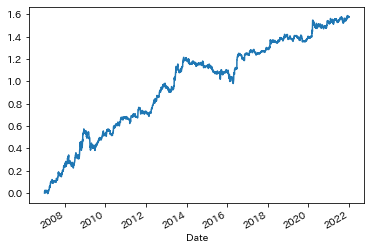

In [155]:
pred = model_o2c.predict(X)

df['pred1'] = pred
df = df.assign(
    exec1 = lambda df: ((df['終値'].shift(1)*0.999<=df['始値'])&(df.pred1<=-0.000))|((df['終値'].shift(1)*1.001>=df['始値'])&(df.pred1>0.000)),
    rate1 = lambda df: (df.o2c * df.pred1.apply(lambda x: 1 if x>0.000 else -1 if  x<-0.000 else 0)).apply(lambda x: 0 if x==0 else x-0.04/365) * df.exec1,
)

df[df.index.year>=2007].rate1.cumsum().plot()
# plt.yscale('log')
plt.show()